# HW1 Food Image Classification

# Get Data
Google Dirve (檔案很大，請盡量先用Kaggle): https://drive.google.com/file/d/1yNYrS3oyRHBcAo6dtelNyAUnF4qI15b9/view?usp=sharing



# 訓練模型
1. 環境: anaconda3 
2. Python: 3.7.16 
3. 模型架構: Tensorflow.keras
4. Cuda_toolkit: 11.3.1
5. CuDNN: 8.4.1

## 匯入所需python package

In [47]:
_exp_name = "8_tf_cnn"
# Import necessary packages
# pip install numpy pandas torch torchvision tqdm
# pip install --upgrade jupyter
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 定義讀取檔案

In [39]:
def readfile(path, label):
    image_dir = sorted(os.listdir(path)) # 將路徑上所有資料進行排序
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8) # 宣告儲存圖片的np.array
    y = np.zeros((len(image_dir)), dtype=np.uint8) # 宣告儲存圖片標籤的np.array
    Z = [] # 回傳檔名
    for i, file in enumerate(image_dir): 
        img = cv2.imread(os.path.join(path, file)) # 用cv2讀取圖片
        x[i, :, :, :] = cv2.resize(img,(128, 128)) # Resize圖片並儲存在x
        
        # If label is True, 從檔名抽取標籤
        if label:
            y[i] = int(file.split("_")[0])
            Z.append(file)
        print(f"reading data:{i+1}/{len(image_dir)}", end="\r")
            
    # If label is True, 回傳x和y; 否則, 只回傳x
    if label:
        return x, y, Z # for training
    else:
        return x    # for testing


## 讀取檔案&&分層抽樣

In [3]:
workspace_dir = 'C:\\Users\\HCX\\Downloads\\HW01\\Dataset'
X, y, Z= readfile(os.path.join(workspace_dir, "training"), True)
# 每個標籤抽9成數據當成訓練集, 剩餘2成當驗證集
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.20, random_state = 891010)

# 打印訓練集和驗證集大小
print(f"Size of training data = {len(train_x)}")
print(f"Size of validation data = {len(val_x)}")

Size of training data = 7892
Size of validation data = 1974


## 資料增強(增加訓練資料的多樣性)

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation((-0.45,0.45)),
  # layers.experimental.preprocessing.RandomContrast(factor=(0.2,0.5)), # 添加後訓練效果不好
])

test_copy = train_x.copy()
label_copy = train_y.copy()
for i in range(len(test_copy)):
  print(f"data augmentation:{i+1}/{len(test_copy)}", end="\r")
  image = tf.cast(tf.expand_dims(test_copy[i], 0), tf.float32)
  for j in range(1):
    augmented_image = data_augmentation(image)
    train_x = np.concatenate((train_x, augmented_image.numpy().astype("uint8")))
    train_y = np.append(train_y, label_copy[i])
    
# 儲存增強後的圖片的目錄
output_dir = "augmented_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for i in range(len(train_x)):
    cv2.imwrite(os.path.join(output_dir, f'{train_y[i]}_{i}.jpg'), train_x[i])
# 儲存增強後的圖片的目錄
output_dir_val = "val_images"
if not os.path.exists(output_dir_val):
    os.makedirs(output_dir_val)
for j in range(len(val_x)):
    cv2.imwrite(os.path.join(output_dir_val, f'{val_y[j]}_{j}.jpg'), val_x[j])

## 讀取已經儲存的圖片(為了方便, 上面就不用跑了)

In [17]:
workspace_dir = 'C:\\Users\\HCX\\Downloads\\HW01'
train_x, train_y, train_z= readfile(os.path.join(workspace_dir, "augmented_images"), True)
val_x, val_y, val_z = readfile(os.path.join(workspace_dir, "val_images"), True)
print(f'{len(train_x)}{train_x.shape}{len(train_y)}{train_y.shape}{len(val_x)}{val_x.shape}{len(val_y)}{val_y.shape}')

15784(15784, 128, 128, 3)15784(15784,)1974(1974, 128, 128, 3)1974(1974,)


In [18]:
train_set, another_train_set, train_label, another_train_label = train_test_split(train_x, train_y, test_size = 0.50, random_state = 891010)

In [32]:
another_train_label.shape

(7892,)

In [33]:
# 檢驗訓練集和驗證集的標籤
train_list = np.zeros(11)
valid_list = np.zeros(11)
for i in range(len(train_label)):
    train_list[train_label[i]] = train_list[train_label[i]]+1
print("train list:{}".format(train_list))
for i in range(len(another_train_label)):
    valid_list[another_train_label[i]] = valid_list[another_train_label[i]]+1
print("valid list:{}".format(valid_list))

train list:[ 805.  359. 1202.  763.  677. 1065.  334.  239.  687. 1190.  571.]
valid list:[ 793.  351. 1206.  779.  641. 1031.  394.  227.  671. 1206.  593.]


## 模型架構

In [37]:
input_shape = (128, 128, 3)

model = models.Sequential(name=f"my_{_exp_name}_model")
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(11, activation='softmax'))

model.summary()

Model: "my_5_tf_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_30 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_31 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_32 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 64)  

## 開始訓練

In [48]:
if tf.config.list_physical_devices('GPU'):
    device = '/device:GPU:0'
else:
    device = '/device:CPU:0'
print(device)

# 設置保存模型的路徑和條件
checkpoint_path = f"{_exp_name}_best.ckpt" # 儲存權重
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

checkpoint_path_cp = f"{_exp_name}_best.h5" # 完整模型
checkpoint_cp = ModelCheckpoint(checkpoint_path_cp, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=2) # 提前終止

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6) # 動態調整學習率

class_weights = {
    0: 2.0,  
    1: 1.0, 
    2: 1.0, 
    3: 1.0, 
    4: 1.0, 
    5: 1.0, 
    6: 1.0, 
    7: 1.0, 
    8: 1.0, 
    9: 1.0, 
    10: 1.0
}

with tf.device(device):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(train_x, train_y, epochs=200, batch_size=32,
                        validation_data=(val_x, val_y), 
                        callbacks=[checkpoint, checkpoint_cp, early_stopping],
                        class_weight=class_weights)

/device:GPU:0
Epoch 1/200
494/494 [==============================] - 144s 287ms/step - loss: 17.5271 - accuracy: 0.1856 - val_loss: 6.0538 - val_accuracy: 0.2639

Epoch 00001: val_accuracy improved from -inf to 0.26393, saving model to 8_tf_cnn_best.ckpt

Epoch 00001: val_accuracy improved from -inf to 0.26393, saving model to 8_tf_cnn_best.h5
Epoch 2/200
298/494 [=================>............] - ETA: 53s - loss: 5.3207 - accuracy: 0.2353

## 繪製圖表

### acc plot

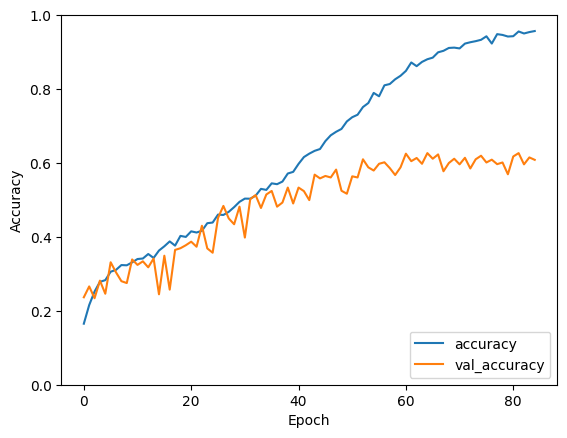

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

### loss plot

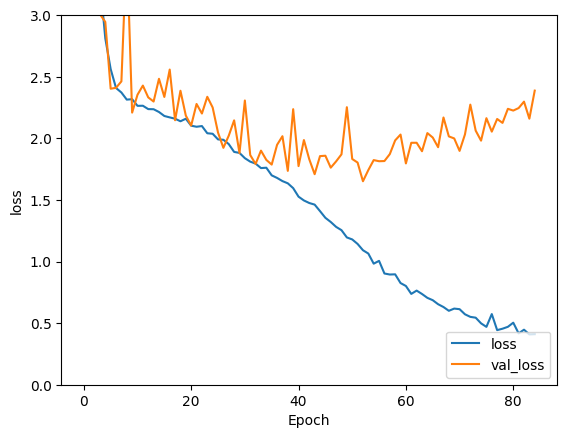

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

### 載入最佳模型

In [42]:
with tf.device('/device:GPU:0'):
    # 加載模型
    loaded_model = load_model(f'C:\\Users\\HCX\\Downloads\\HW01\\{_exp_name}_best.h5')
    predictions = loaded_model.predict(val_x)
    predicted_labels = np.argmax(predictions, axis=1)
    times = 0
    for i in range(len(val_x)):
        index = i
        classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
        if val_y[index] == predicted_labels[index]:
            times += 1
        # else:
        #     rgb_img = cv2.cvtColor(val_x[index], cv2.COLOR_BGR2RGB)
        #     plt.imshow(rgb_img)# 显示图像
        #     plt.axis('off')  # 关闭坐标轴
        #     plt.show()
    print(f'acc {times/len(val_x)}')

acc 0.7061803444782169


### confusion metrix plot

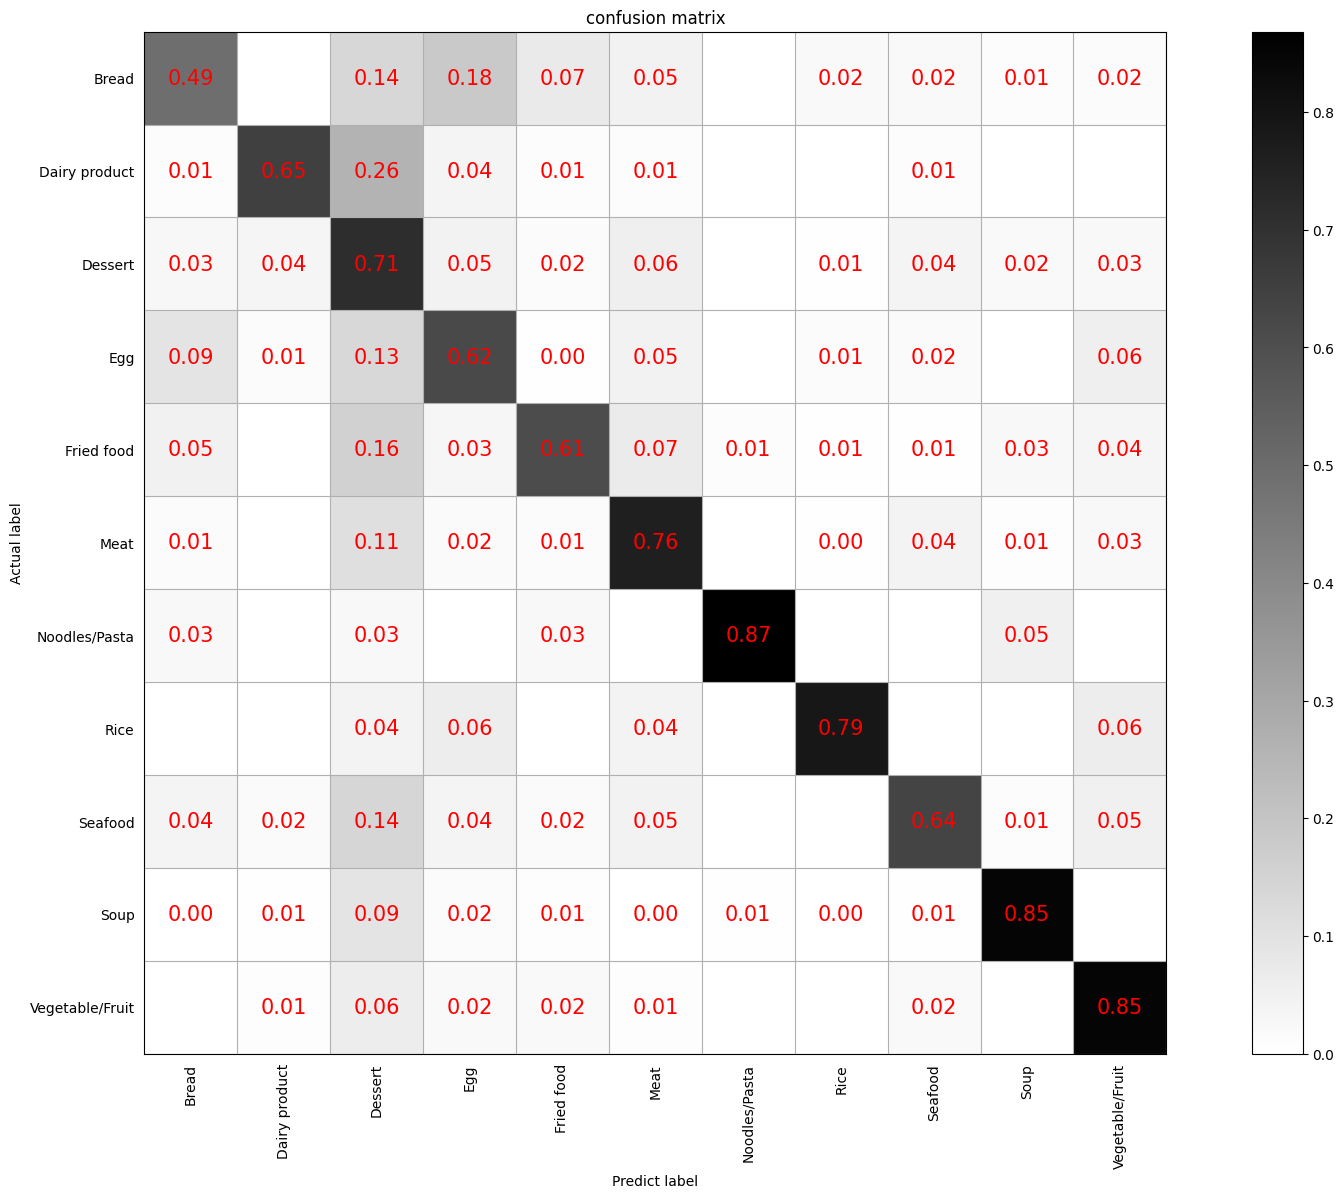

In [43]:
classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
y_true = val_y.copy()  
y_pred = predicted_labels.copy()  
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(22, 14), dpi=100)
    np.set_printoptions(precision=2)

    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')

    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)

    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()
plot_confusion_matrix(cm_normalized, f'{_exp_name}_confusion_matrix.png', title='confusion matrix')

# 建立預測標籤檔案

In [25]:
workspace_dir = 'C:\\Users\\HCX\\Downloads\\HW01\\Dataset'
test_set = readfile(os.path.join(workspace_dir, "testing"), False)
predictions_test = loaded_model.predict(test_set)
predicted_test_labels = np.argmax(predictions_test, axis=1)
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = predicted_test_labels
df.to_csv(f"{_exp_name}_submission.csv",index = False)

# 測試用的程式碼

In [ ]:
# plt.imshow()
# plt.axis('off')  # 关闭坐标轴
# plt.show()

# 再訓練模型

In [6]:
if tf.config.list_physical_devices('GPU'):
    device = '/device:GPU:0'
else:
    device = '/device:CPU:0'
print(device)

# 設置保存模型的路徑和條件
checkpoint_path = f"{_exp_name}_best.ckpt" # 儲存權重
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

checkpoint_path_cp = f"{_exp_name}_best.h5" # 完整模型
checkpoint_cp = ModelCheckpoint(checkpoint_path_cp, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=2) # 提前終止

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6) # 動態調整學習率

with tf.device(device):
    loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = loaded_model.fit(train_x, train_y, epochs=200, batch_size=32, validation_data=(val_x, val_y), callbacks=[checkpoint, checkpoint_cp, early_stopping])

/device:GPU:0
Epoch 1/200
494/494 [==============================] - 146s 287ms/step - loss: 0.8541 - accuracy: 0.8059 - val_loss: 1.5155 - val_accuracy: 0.6621

Epoch 00001: val_accuracy improved from -inf to 0.66211, saving model to 5_tf_cnn_best.ckpt

Epoch 00001: val_accuracy improved from -inf to 0.66211, saving model to 5_tf_cnn_best.h5
Epoch 2/200
494/494 [==============================] - 139s 281ms/step - loss: 0.8360 - accuracy: 0.8093 - val_loss: 1.5937 - val_accuracy: 0.6241

Epoch 00002: val_accuracy did not improve from 0.66211

Epoch 00002: val_accuracy did not improve from 0.66211
Epoch 3/200
494/494 [==============================] - 139s 281ms/step - loss: 0.8042 - accuracy: 0.8196 - val_loss: 1.4557 - val_accuracy: 0.6778

Epoch 00003: val_accuracy improved from 0.66211 to 0.67781, saving model to 5_tf_cnn_best.ckpt

Epoch 00003: val_accuracy improved from 0.66211 to 0.67781, saving model to 5_tf_cnn_best.h5
Epoch 4/200
494/494 [==============================] - 139s

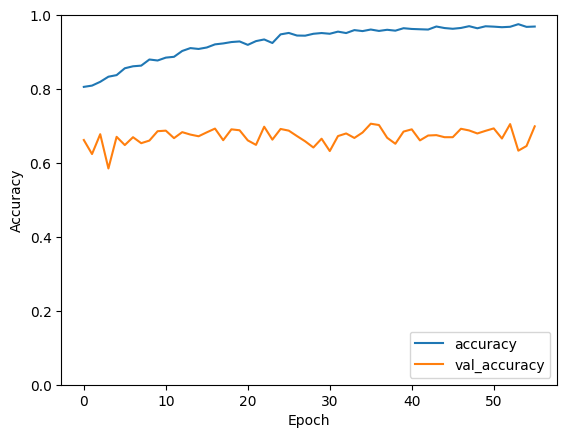

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

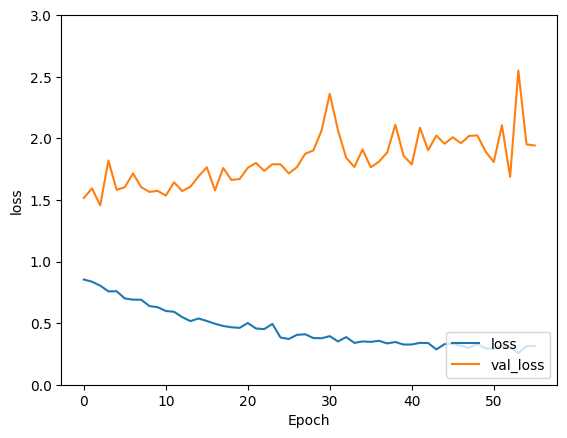

In [8]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

acc 0.7061803444782169


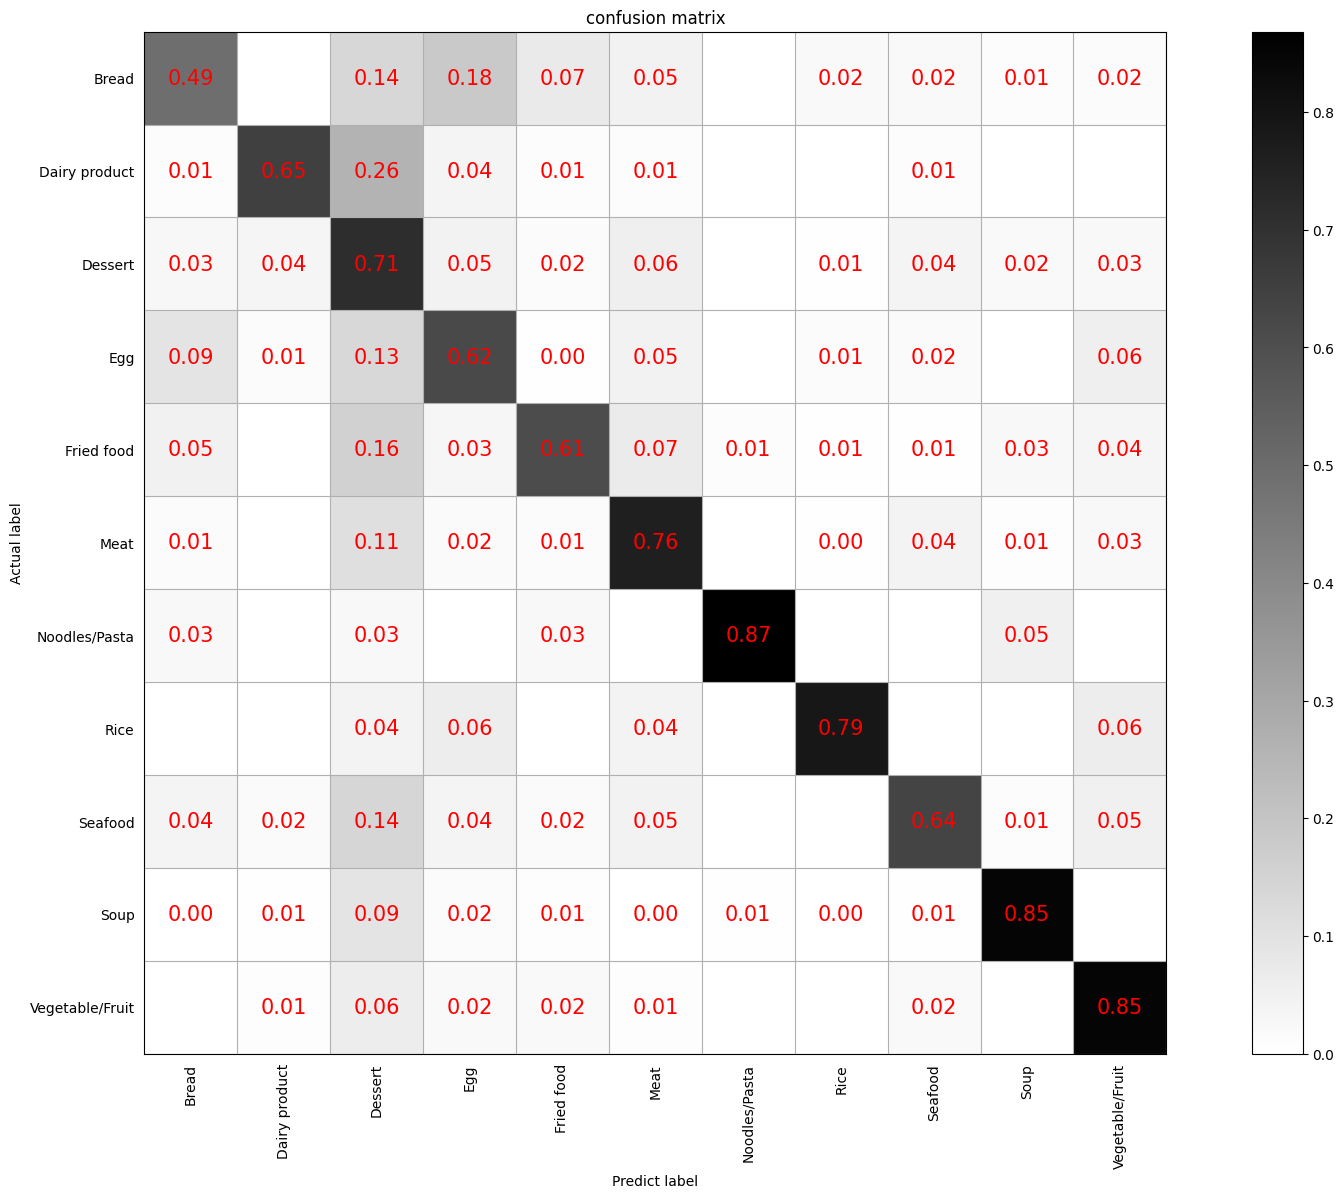

In [9]:
with tf.device('/device:GPU:0'):
    # 加載模型
    loaded_model = load_model(f'C:\\Users\\HCX\\Downloads\\HW01\\{_exp_name}_best.h5')
    predictions = loaded_model.predict(val_x)
    predicted_labels = np.argmax(predictions, axis=1)
    times = 0
    for i in range(len(val_x)):
        index = i
        classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
        if val_y[index] == predicted_labels[index]:
            times += 1
        # else:
        #     rgb_img = cv2.cvtColor(val_x[index], cv2.COLOR_BGR2RGB)
        #     plt.imshow(rgb_img)# 显示图像
        #     plt.axis('off')  # 关闭坐标轴
        #     plt.show()
    print(f'acc {times/len(val_x)}')
classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
y_true = val_y.copy()  
y_pred = predicted_labels.copy()  
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(22, 14), dpi=100)
    np.set_printoptions(precision=2)

    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')

    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)

    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()
plot_confusion_matrix(cm_normalized, f'{_exp_name}_confusion_matrix.png', title='confusion matrix')

In [46]:
if tf.config.list_physical_devices('GPU'):
    device = '/device:GPU:0'
else:
    device = '/device:CPU:0'
print(device)

# 設置保存模型的路徑和條件
checkpoint_path = f"re_{_exp_name}_best.ckpt" # 儲存權重
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

checkpoint_path_cp = f"re_{_exp_name}_best.h5" # 完整模型
checkpoint_cp = ModelCheckpoint(checkpoint_path_cp, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=2) # 提前終止

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6) # 動態調整學習率

class_weights = {
    0: 2.0,  
    1: 1.0, 
    2: 1.0, 
    3: 1.0, 
    4: 1.0, 
    5: 1.0, 
    6: 1.0, 
    7: 1.0, 
    8: 1.0, 
    9: 1.0, 
    10: 1.0
}

with tf.device(device):
    loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                         metrics=['accuracy'])

    history = loaded_model.fit(train_set, train_label, epochs=200, batch_size=32,
                               validation_data=(val_x, val_y), 
                               callbacks=[checkpoint, checkpoint_cp, early_stopping],
                               class_weight=class_weights)


/device:GPU:0
Epoch 1/200
247/247 [==============================] - 73s 288ms/step - loss: 0.3619 - accuracy: 0.9554 - val_loss: 1.8243 - val_accuracy: 0.6839

Epoch 00001: val_accuracy improved from -inf to 0.68389, saving model to re_5_tf_cnn_best.ckpt

Epoch 00001: val_accuracy improved from -inf to 0.68389, saving model to re_5_tf_cnn_best.h5
Epoch 2/200
247/247 [==============================] - 70s 285ms/step - loss: 0.3250 - accuracy: 0.9655 - val_loss: 1.8084 - val_accuracy: 0.6814

Epoch 00002: val_accuracy did not improve from 0.68389

Epoch 00002: val_accuracy did not improve from 0.68389
Epoch 3/200
247/247 [==============================] - 70s 285ms/step - loss: 0.3382 - accuracy: 0.9629 - val_loss: 1.8428 - val_accuracy: 0.6814

Epoch 00003: val_accuracy did not improve from 0.68389

Epoch 00003: val_accuracy did not improve from 0.68389
Epoch 4/200
 23/247 [=>............................] - ETA: 1:00 - loss: 0.3565 - accuracy: 0.9552

KeyboardInterrupt: 